---
## 7. 탄소중립 시나리오를 통한 미래 이산화탄소 농도 예측

#### 7-0. 라이브러리 호출

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
import numpy as np
from sklearn.metrics import mean_absolute_error

#### 7-1. 데이터 호출 및 시각화

In [2]:
# 이산화탄소 농도 데이터 (연도별 데이터로 변경)
co2_ppm = pd.read_csv('./DB/co2_mm_mlo.csv')
co2_ppm = co2_ppm.groupby('year')['average'].mean().reset_index()
co2_ppm.rename(columns={'average':'CO2(ppm)'}, inplace=True)

In [3]:
# train, test split
train_co2_ppm = co2_ppm[co2_ppm['year'] <= 2003]
target_co2_ppm = co2_ppm[co2_ppm['year'] > 2003]

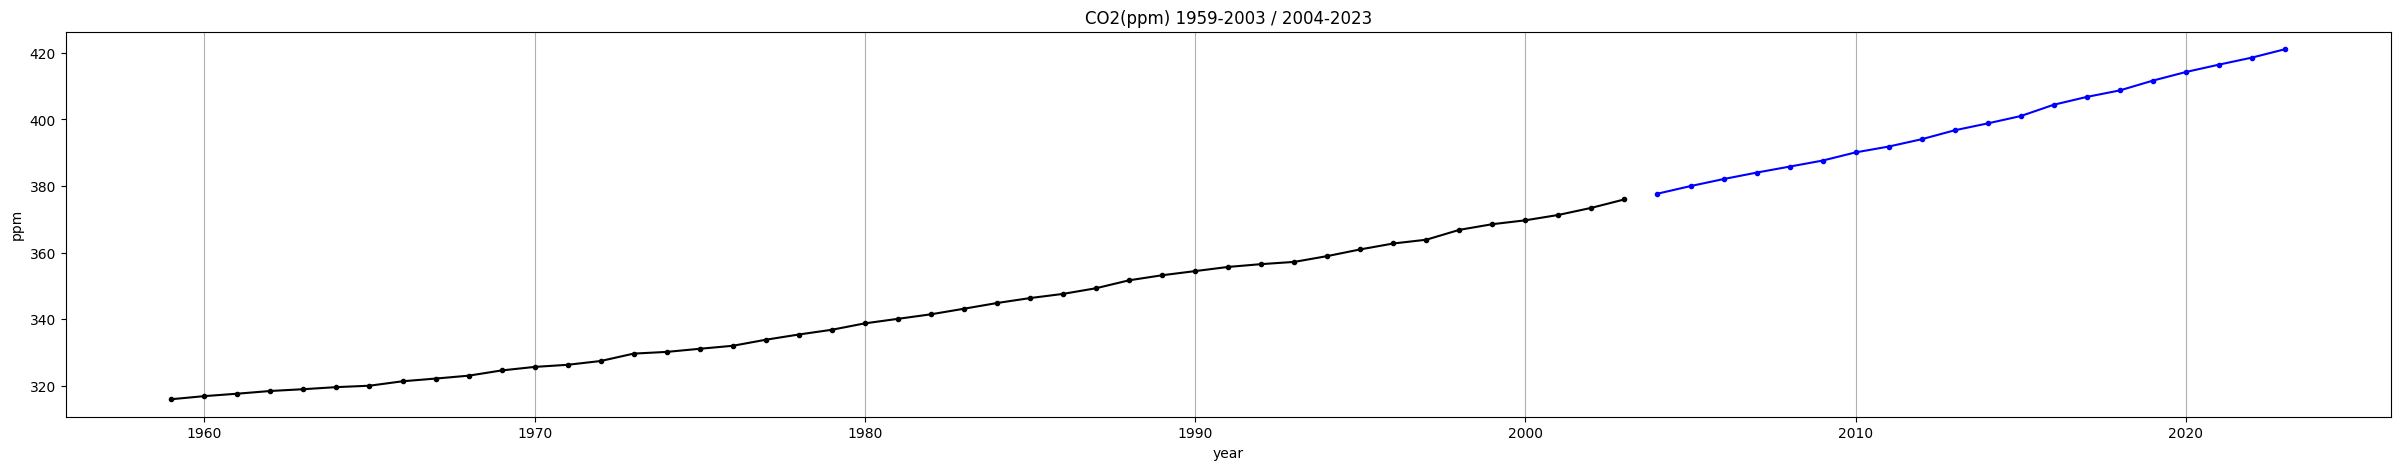

In [4]:
# train, test 시각화
plt.figure(figsize=(30,5))
plt.plot(train_co2_ppm['year'], train_co2_ppm['CO2(ppm)'], marker='.', color='black')
plt.plot(target_co2_ppm['year'], target_co2_ppm['CO2(ppm)'], marker='.', color='blue')
plt.title('CO2(ppm) 1959-2003 / 2004-2023')
plt.grid(axis='x'); plt.xlabel('year'); plt.ylabel('ppm')
plt.show()

In [5]:
# 이산화탄소 배출량 데이터
co2_emission = pd.read_csv('./DB/co2_emissions.csv')

In [6]:
# train test split
train_co2_emission = co2_emission[co2_emission['year'] <= 2003]
target_co2_emission = co2_emission[co2_emission['year'] > 2003]

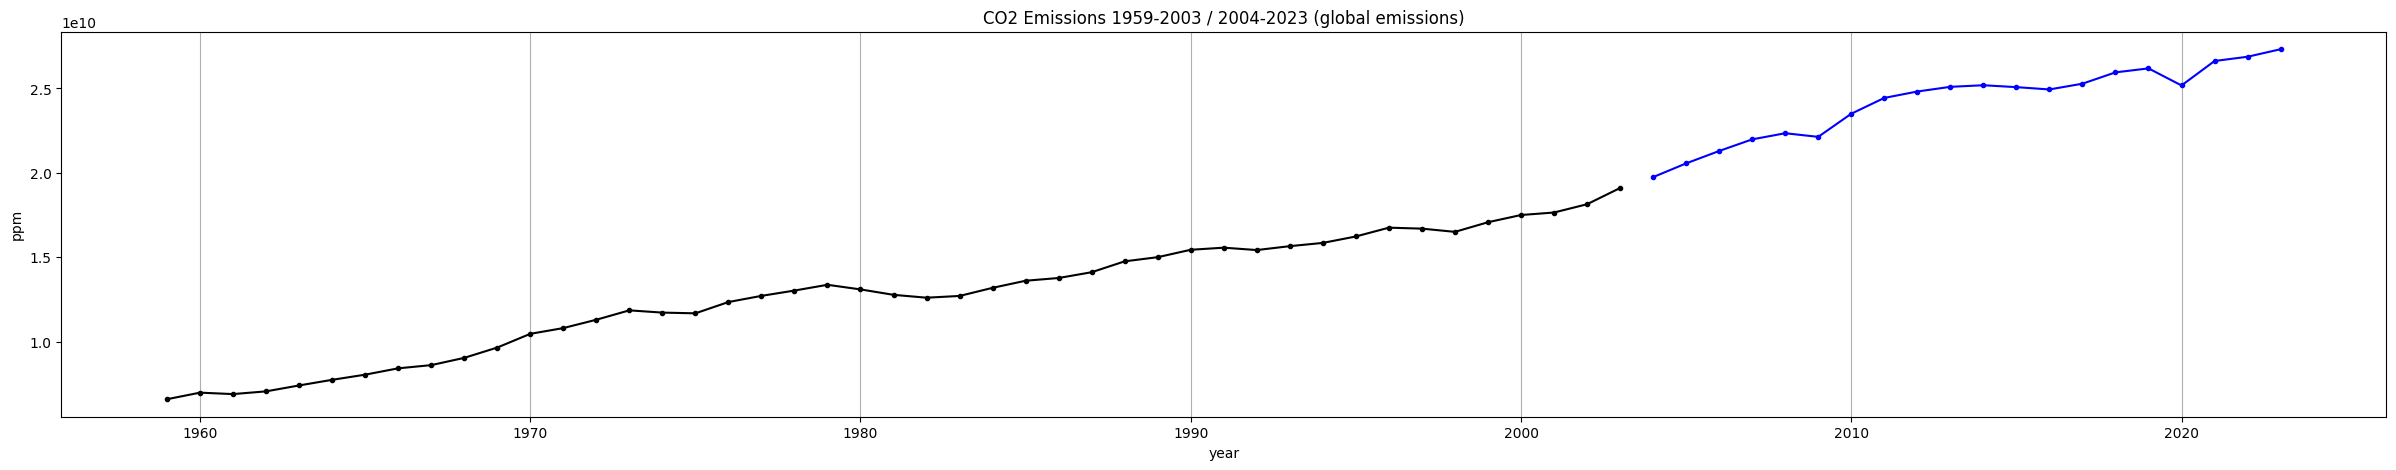

In [7]:
# train, test 시각화
plt.figure(figsize=(30,5))
plt.plot(train_co2_emission['year'], train_co2_emission['Global_Emissions'], marker='.', color='black')
plt.plot(target_co2_emission['year'], target_co2_emission['Global_Emissions'], marker='.', color='blue')
plt.title('CO2 Emissions 1959-2003 / 2004-2023 (global emissions)')
plt.grid(axis='x'); plt.xlabel('year'); plt.ylabel('ppm')
plt.show()

#### 7-2. SARIMAX

In [8]:
# p, d, q 설정
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [None for x in pdq]

In [9]:
# 모델 설정
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

In [10]:
warnings.filterwarnings('ignore')
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(
                endog=train_co2_ppm['CO2(ppm)'],
                exog=train_co2_emission['Global_Emissions'],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = temp_model.fit(disp=False)

            if result.aic < best_aic:
                print(f"SARIMAX{param}x{param_seasonal} - AIC: {result.aic}")
                best_aic = result.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = temp_model

        except Exception as e:
            print(f"Error with SARIMAX{param}x{param_seasonal}: {e}")
            continue

print(f"Best SARIMAX{best_pdq}x{best_seasonal_pdq} - AIC: {best_aic}")
# Best SARIMAX(0, 1, 0)x(1, 2, 0, 12) - AIC: 68.23781917025659
# Best SARIMAX(0, 2, 1)x(2, 0, 0, 12) - AIC: -334.855793630176 (Normalization)

SARIMAX(0, 0, 0)xNone - AIC: 629.7508608830315
SARIMAX(0, 0, 1)xNone - AIC: 456.09186008714795
SARIMAX(0, 1, 0)xNone - AIC: 251.03620425268053
SARIMAX(0, 1, 1)xNone - AIC: 118.32321379311092
SARIMAX(1, 1, 0)xNone - AIC: 115.4585120236896
SARIMAX(1, 1, 1)xNone - AIC: 111.2378074784233
Best SARIMAX(1, 1, 1)xNone - AIC: 111.2378074784233


In [11]:
model = SARIMAX(
    endog=train_co2_ppm['CO2(ppm)'],
    exog=train_co2_emission['Global_Emissions'],
    order=(2,1,2)
)
result = model.fit(disp=False)
print(result.params)

Global_Emissions    2.588831e-09
ar.L1               3.201966e-01
ar.L2               5.782255e-01
ma.L1               1.059242e-01
ma.L2              -5.387150e-01
sigma2              7.411543e-01
dtype: float64


In [12]:
pred = result.get_prediction(
    start=len(train_co2_ppm),
    end=len(train_co2_ppm) + len(target_co2_ppm) - 1,
    exog=target_co2_emission['Global_Emissions']
)

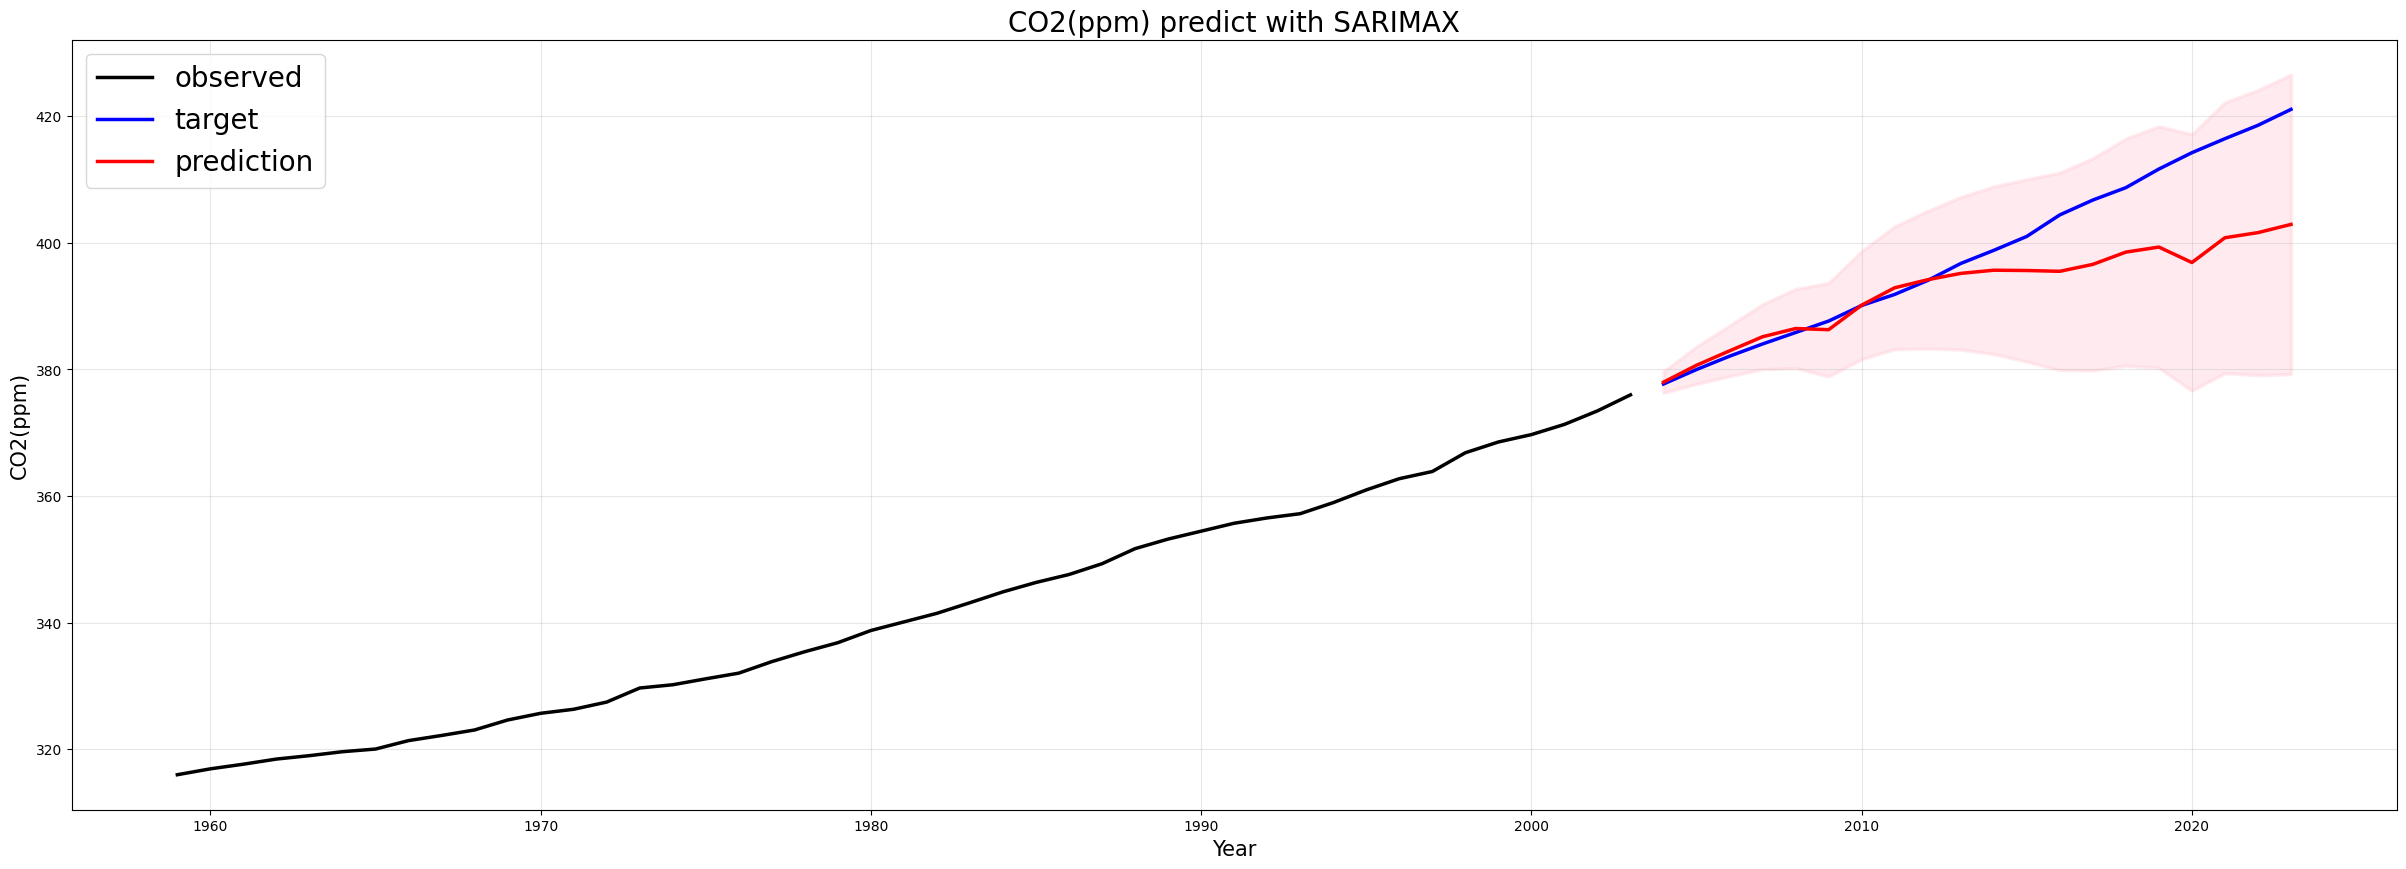

In [13]:
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean

plt.figure(figsize=(30,10))
plt.grid(True, alpha=0.3)
plt.plot(train_co2_ppm['year'], train_co2_ppm['CO2(ppm)'], color='black', linewidth=2.5, label='observed')
plt.plot(target_co2_ppm['year'], target_co2_ppm['CO2(ppm)'], color='blue', linewidth=2.5, label='target')
plt.plot(target_co2_ppm['year'], pred_mean, color='red', label='prediction', linewidth=2.5)
# 신뢰구간 plot
plt.title('CO2(ppm) predict with SARIMAX', fontsize=20)
plt.fill_between(target_co2_ppm['year'], pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3, linewidth=2.5)
plt.legend(fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('CO2(ppm)', fontsize=15)
plt.show()

In [14]:
mae_error = mean_absolute_error(target_co2_ppm['CO2(ppm)'], pred_mean)
print(mae_error)

6.296943129409345


In [15]:
correlation = np.corrcoef(train_co2_ppm['CO2(ppm)'], train_co2_emission['Global_Emissions'])[0, 1]
print(f"Correlation between CO2 ppm and CO2 Emissions: {correlation}")

Correlation between CO2 ppm and CO2 Emissions: 0.9728623712104348


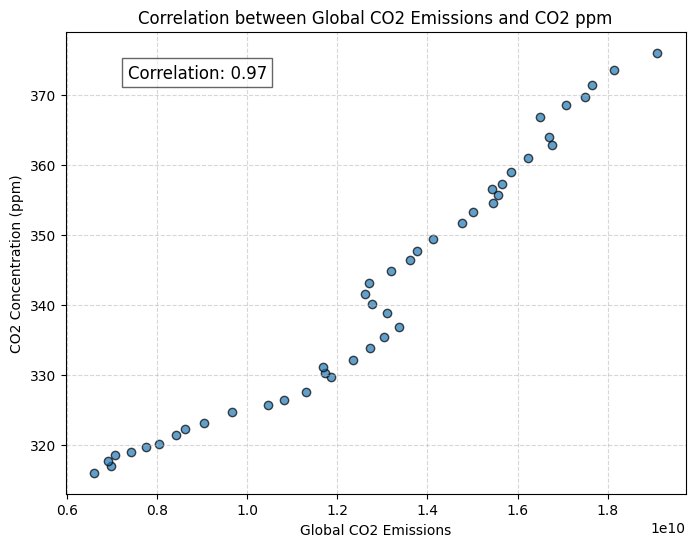

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(train_co2_emission['Global_Emissions'], train_co2_ppm['CO2(ppm)'], alpha=0.7, edgecolors='k', label='Data points')
plt.title('Correlation between Global CO2 Emissions and CO2 ppm')
plt.xlabel('Global CO2 Emissions')
plt.ylabel('CO2 Concentration (ppm)')
plt.grid(True, linestyle='--', alpha=0.5)

# 상관계수 표시
correlation = np.corrcoef(train_co2_emission['Global_Emissions'], train_co2_ppm['CO2(ppm)'])[0, 1]
plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

plt.show()

#### 7-3. 2024~2050 예측

In [17]:
# 1959 ~ 2023 이산화탄소 농도 호출
co2_ppm = pd.read_csv('./DB/co2_mm_mlo.csv')
co2_ppm = co2_ppm.groupby('year')['average'].mean().reset_index()
co2_ppm.rename(columns={'average':'CO2(ppm)'}, inplace=True)

In [18]:
# 1959 ~ 2023 이산화탄소 배출량 데이터
co2_emission = pd.read_csv('./DB/co2_emissions.csv')

In [19]:
model = SARIMAX(
    endog=co2_ppm['CO2(ppm)'],
    exog=co2_emission['Global_Emissions'],
    order=(2,1,2)   # (p,d,q)의 d는 차분이며 d가 커질수록 exog 영향령 작아짐
)
result = model.fit(disp=False)

#### Case 1. 탄소중립 선언 국가 탄소중립 성공

In [20]:
# 2024~2050 이산화탄소 배출량 데이터
normal = pd.read_csv('./DB/2024-2050_co2_emission.csv')[65:]
normal['scaled'] = (normal['Global_Emissions'] - normal['Global_Emissions'].min()) / (normal['Global_Emissions'].max() - normal['Global_Emissions'].min())

In [21]:
pred_1 = result.get_prediction(
    start=len(co2_emission),
    end=len(co2_emission) + len(normal) - 1,
    exog=normal['Global_Emissions'],
    dynamic=False
)

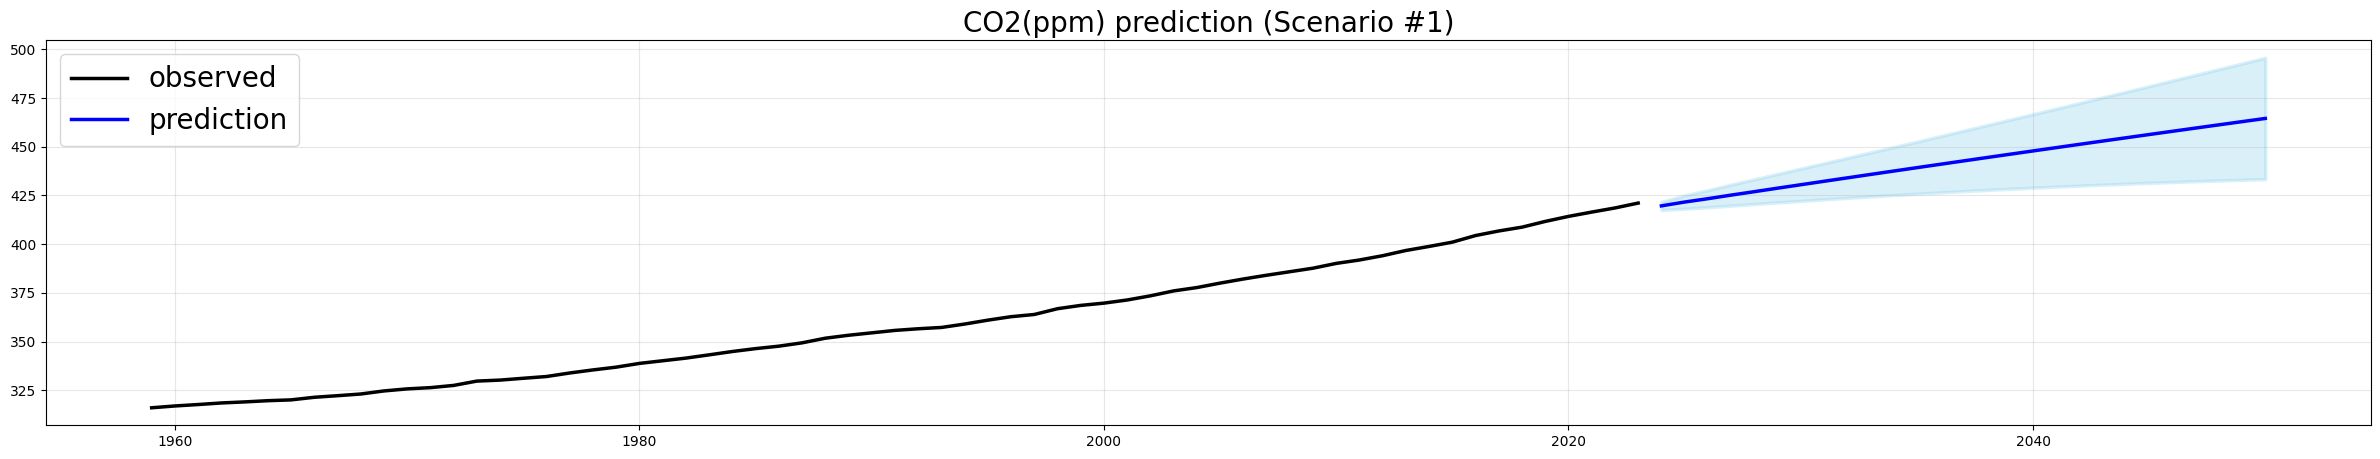

In [22]:
pred_ci_1 = pred_1.conf_int()
pred_mean_1 = pred_1.predicted_mean

plt.figure(figsize=(30,5))
plt.grid(True, alpha=0.3)
plt.plot(co2_ppm['year'], co2_ppm['CO2(ppm)'], color='black', linewidth=2.5, label='observed')
plt.plot(normal['Unnamed: 0'], pred_mean_1, color='blue', label='prediction', linewidth=2.5)
# 신뢰구간 plot
plt.fill_between(normal['Unnamed: 0'], pred_ci_1.iloc[:, 0], pred_ci_1.iloc[:, 1], color='skyblue', alpha=0.3, linewidth=2.5)
plt.legend(fontsize=20)
plt.title('CO2(ppm) prediction (Scenario #1)', fontsize=20)
plt.show()

#### Case 2. 탄소중립 실패

In [23]:
# 2024~2050 이산화탄소 배출량 데이터
fail = pd.read_csv('./DB/2024-2050_co2_emission_fail_version.csv')[65:]
fail['scaled'] = (fail['Global_Emissions'] - fail['Global_Emissions'].min()) / (fail['Global_Emissions'].max() - fail['Global_Emissions'].min())

In [24]:
pred_2 = result.get_prediction(
    start=len(co2_emission),
    end=len(co2_emission) + len(fail) - 1,
    exog=fail['Global_Emissions'],
)

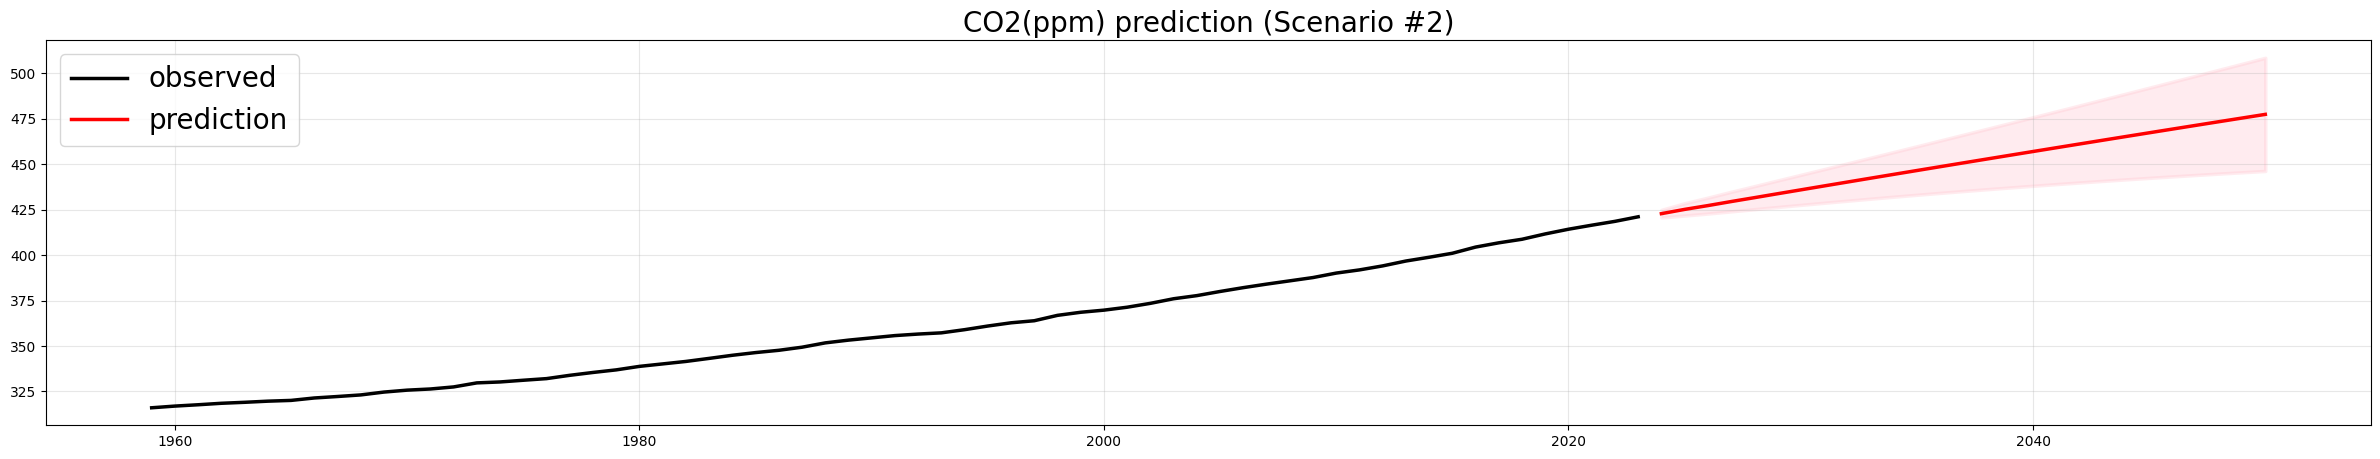

In [25]:
pred_ci_2 = pred_2.conf_int()
pred_mean_2 = pred_2.predicted_mean

plt.figure(figsize=(30,5))
plt.grid(True, alpha=0.3)
plt.plot(co2_ppm['year'], co2_ppm['CO2(ppm)'], color='black', linewidth=2.5, label='observed')
plt.plot(fail['Unnamed: 0'], pred_mean_2, color='red', label='prediction', linewidth=2.5)
# 신뢰구간 plot
plt.fill_between(fail['Unnamed: 0'], pred_ci_2.iloc[:, 0], pred_ci_2.iloc[:, 1], color='pink', alpha=0.3, linewidth=2.5)
plt.legend(fontsize=20)
plt.title('CO2(ppm) prediction (Scenario #2)', fontsize=20)
plt.show()

#### Case 3. 전세계 탄소중립 성공

In [26]:
# 2024~2050 이산화탄소 배출량 데이터
success = pd.read_csv('./DB/2024-2050_co2_emission_success_version.csv')[65:]
success['scaled'] = (success['Global_Emissions'] - success['Global_Emissions'].min()) / (success['Global_Emissions'].max() - success['Global_Emissions'].min())

In [27]:
pred_3 = result.get_prediction(
    start=len(co2_emission),
    end=len(co2_emission) + len(success) - 1,
    exog=success['Global_Emissions']
)

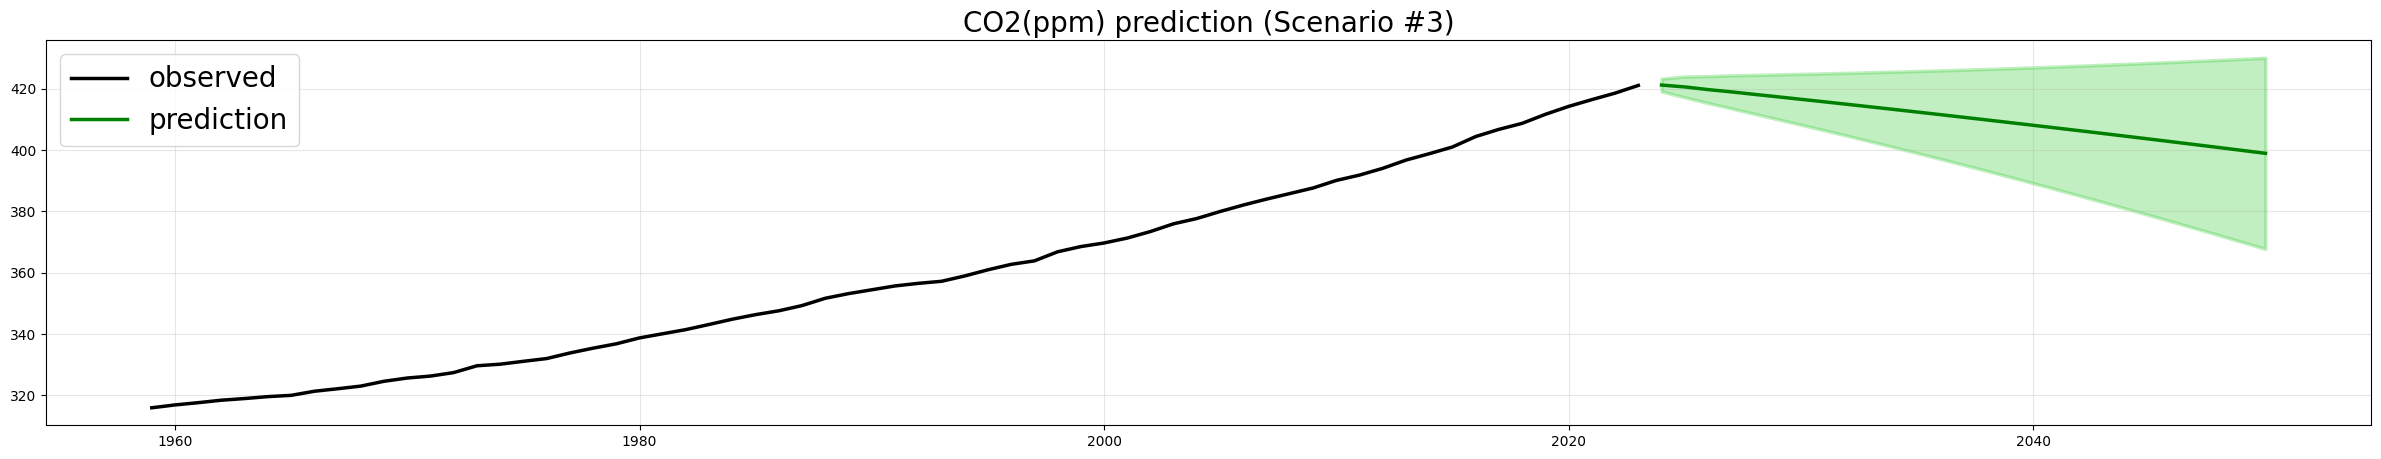

In [28]:
pred_ci_3 = pred_3.conf_int()
pred_mean_3 = pred_3.predicted_mean

plt.figure(figsize=(30,5))
plt.grid(True, alpha=0.3)
plt.plot(co2_ppm['year'], co2_ppm['CO2(ppm)'], color='black', linewidth=2.5, label='observed')
plt.plot(success['Unnamed: 0'], pred_mean_3, color='green', label='prediction', linewidth=2.5)
# 신뢰구간 plot
plt.fill_between(success['Unnamed: 0'], pred_ci_3.iloc[:, 0], pred_ci_3.iloc[:, 1], color='limegreen', alpha=0.3, linewidth=2.5)
plt.legend(fontsize=20)
plt.title('CO2(ppm) prediction (Scenario #3)', fontsize=20)
plt.show()

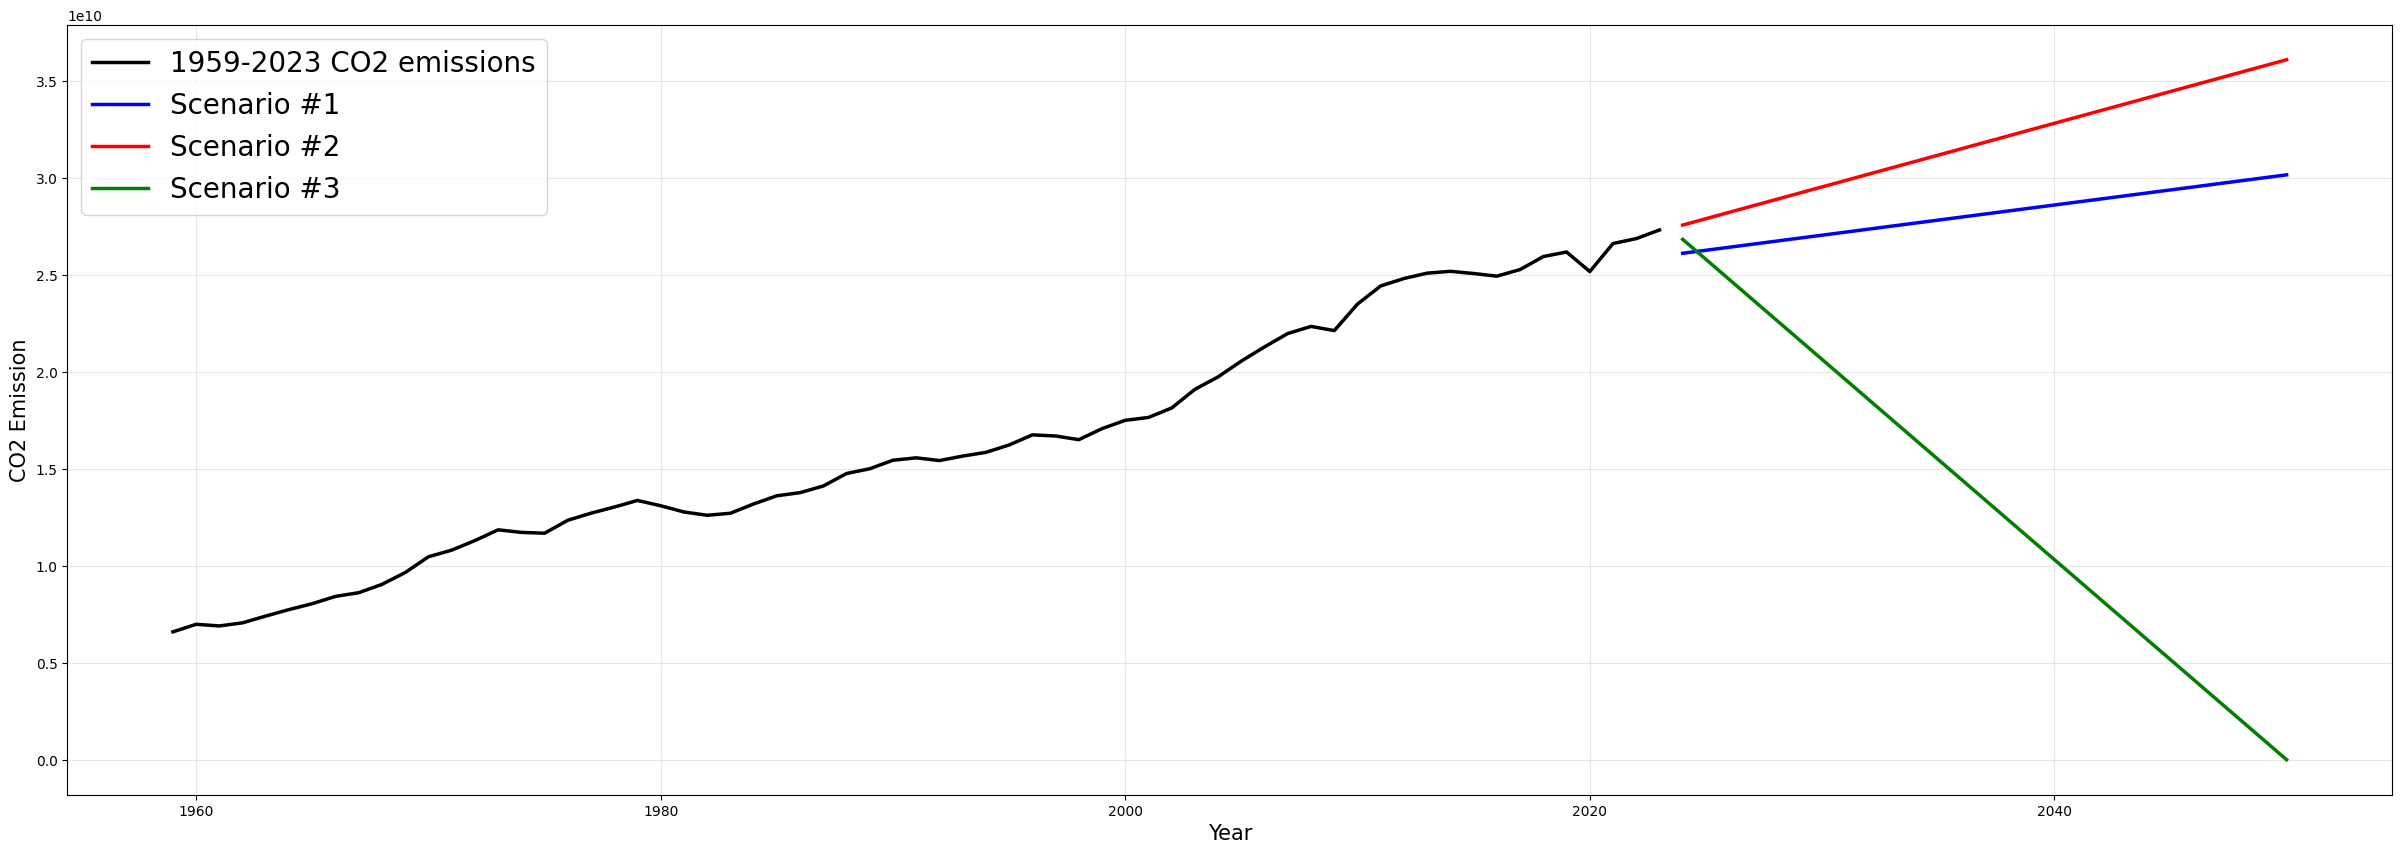

In [29]:
plt.figure(figsize=(30,10))
plt.grid(True, alpha=0.3)
plt.plot(co2_emission['year'], co2_emission['Global_Emissions'], color='black', label='1959-2023 CO2 emissions', linewidth=2.5)
plt.plot(normal['Unnamed: 0'], normal['Global_Emissions'], color='blue', label='Scenario #1', linewidth=2.5)
plt.plot(fail['Unnamed: 0'], fail['Global_Emissions'], color='red', label='Scenario #2', linewidth=2.5)
plt.plot(success['Unnamed: 0'], success['Global_Emissions'], color='green', label='Scenario #3', linewidth=2.5)
plt.legend(fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('CO2 Emission', fontsize=15)
plt.show()

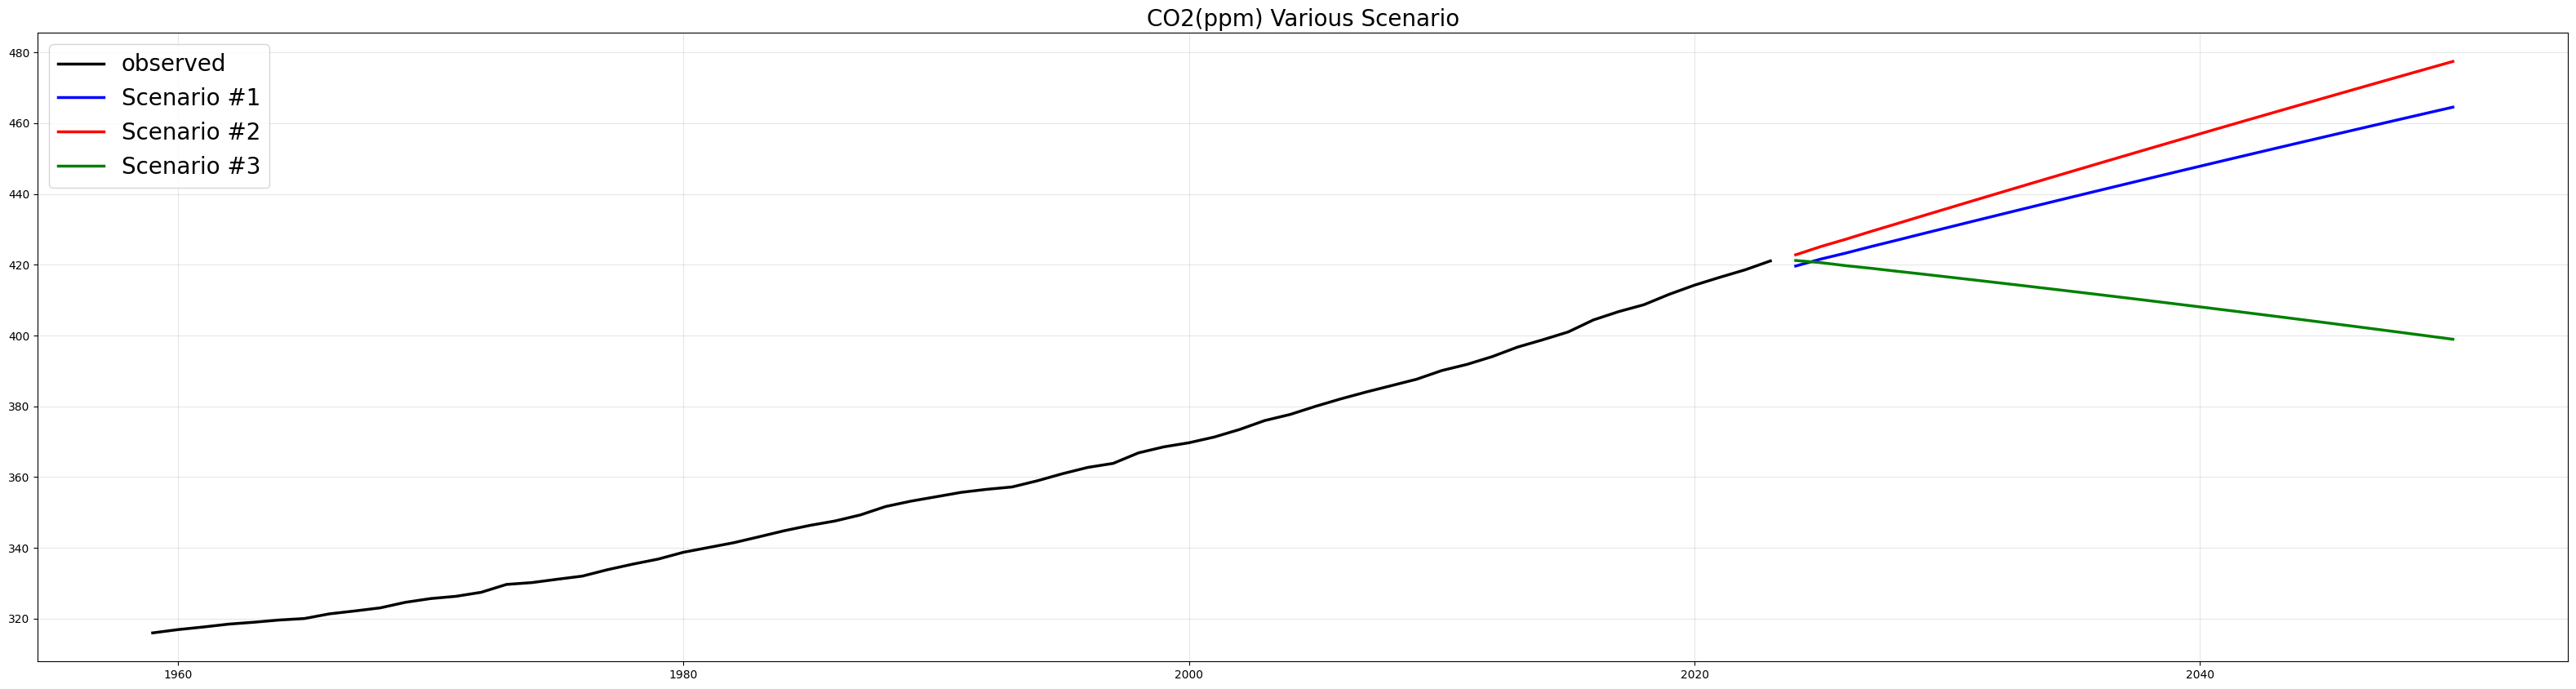

In [30]:
plt.figure(figsize=(40,10))
plt.title('CO2(ppm) Various Scenario', fontsize=20)
plt.grid(True, alpha=0.3)
plt.plot(co2_ppm['year'], co2_ppm['CO2(ppm)'], color='black', linewidth=2.5, label='observed')
plt.plot(normal['Unnamed: 0'], pred_mean_1, color='blue', label='Scenario #1', linewidth=2.5)
plt.plot(fail['Unnamed: 0'], pred_mean_2, color='red', label='Scenario #2', linewidth=2.5)
plt.plot(success['Unnamed: 0'], pred_mean_3, color='green', label='Scenario #3', linewidth=2.5)
plt.legend(fontsize=20)
plt.show()

In [31]:
# pred_mean_1.to_csv('./DB/scenario_local_zero.csv')

In [32]:
# pred_mean_2.to_csv('./DB/scenario_not_zero.csv')

In [33]:
# pred_mean_3.to_csv('./DB/scenario_global_zero.csv')